# Reactive transport
In this tutorial we investigate the numerical solution of a chemical system with kinetics reactions and reactions at equilibrium.

## Exercise 2: chemical reactions kinetics and at equilibrium

Let us consider the following set of reactions:
\begin{align*}
&A\leftarrow 2B+C\\
&2B+C\rightarrow A\\
&C\rightarrow D
\end{align*}
but this time, we consider $A\leftrightarrow 2B+C$ to be at equilibrium, i.e. the forward and backward reactions, with rates $r_0$ and $r_1$, proceed so fast that, at the time scale of interest, we reach equilibrium immediately.So, the first two reactions translate into the following algebraic relation:
\begin{gather*}
k_{eq}=\dfrac{k_0}{k_1} = \dfrac{[B]^2[C]}{[A]}
\end{gather*}
Unlike the first two, the third reaction is modeled as kinetic and has rate $r_2=k_{kin}[C]$. Let us derive the associated problem to solve.

In principle the concentrations $c_0=[A]$, $c_1=[B]$, $c_2=[C]$, $c_3=[D]$ are solution of the following ODE system:
\begin{gather*}
    {d_t {c}} = S{r}({c})
\end{gather*}
where the stoichiometric matrix $S$ is the following
\begin{gather*}
    S =
    \begin{bmatrix}
        -1 & 1 & 0\\
        2 & -2 & 0\\
        1 & -1 & -1\\
        0 & 0 & 1
    \end{bmatrix}
\end{gather*}
and, for given $k_i$, the reaction equations are given by
\begin{align*}
   &A\rightarrow 2B+C & \Rightarrow \quad & r_0({c}) = k_0 c_0\\
   &2B+C\rightarrow A & \Rightarrow \quad & r_1({c}) = k_1 c_1^2 c_2\\
   &C\rightarrow D & \Rightarrow \quad & r_2({c}) = k_{kin} c_2
\end{align*}

Thus the final system becomes
\begin{gather*}
    {d_t {c}} = S{r}({c})=
    \begin{bmatrix}
        -r_0(c) + r_1(c)\\
        2 r_0(c) - 2r_1(c)\\
        r_0(c) - r_1(c) - r_2(c)\\
        r_2(c)
    \end{bmatrix}
\end{gather*}

However, we want to get rid of the fast reaction rate and exploit the fact that, thanks to the equilibrium reaction, we can express one of the unknowns as a function of the others, for instance:
\begin{gather*}
k_{eq}c_0= {c_1^2 c_2}{}.
\end{gather*}
Therefore we can define 3 total concentrations $\psi_0$, $\psi_1$, $\psi_2$ as follows:
\begin{align*}
\psi_0 &= 2c_0 + c_1 \\
\psi_1 &= c_0 + c_2\\
\psi_2 &= c_3
\end{align*}
In this way, we are obtaining the following system where $r_{0}$ and $r_1$ are not present
\begin{align*}
&{d_t \psi_0} = 2{d_t c_0} + {d_t c_1} = -2 r_{eq}(c) + 2 r_{eq}(c) =0\\
&{d_t \psi_1} = {d_t c_0} + {d_t c_2} =  - r_{eq}(c) + r_{eq}(c) -  r_{2}(c) =-r_2(c)\\
&{d_t \psi_2} = {d_t c_3}  = r_2(c)
\end{align*}



Let us fist consider some standard packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We define now the kinetics coefficents of the reaction.

In [2]:
# define the kinetics coefficients
k_kin = 1
k_eq = 1

We can define the right hand side for the ODE system for $\psi_i$ which now depends only on the second, slow reaction rate $r_2= k_{kin} c_2$.

In [3]:
# concentrations = [A,B,C,D], total concentrations [psi1, psi2, psi3]
def f(t, c):
    r_2 = k_kin * c[2]
    return np.array([0, -r_2, r_2])

However, since reaction rate depends on the real concentrations, this implies that at each time step we must be able to find $c_i$, $i=0,\ldots 3$ given the total ones $\psi_j$, $j=0,\ldots, 2$ solving the following nonlinear system:
\begin{gather*}
\begin{cases}
\psi_0 - 2c_0- c_1&=0\\
\psi_1 - c_0- c_2  &=0\\
\psi_2 - c_3 &=0\\
k_{eq}c_0 - c_1^2c_2&=0
\end{cases}
\end{gather*}
with any root finding method, for instance a Newton method for systems, considering that at each iteration we have to assemble the jacobian as
\begin{gather*}
J=\left[\begin{array}{cccc} -2 & -1 & 0 & 0\\ -1 & 0 & -1 & 0\\ 0 & 0 & 0 & -1\\ k_{eq}& -2c_1^{k}c_2^{k}& -(c_1^{k})^2& 0  \end{array}\right]
\end{gather*}
The associated Newton method can be written as

In [4]:
def find_conc(psi, c_old, tol=1e-10, maxit=1e2):
    c = c_old.copy()
    err = tol + 1
    count = 0

    while err > tol and count < maxit:
        # compute the residual
        res = np.array(
            [
                psi[0] - 2 * c[0] - c[1],
                psi[1] - c[2] - c[0],
                psi[2] - c[3],
                k_eq * c[0] - c[1] * c[1] * c[2],
            ]
        )
        # update the Jacobian
        jac = np.array(
            [
                [-2, -1, 0, 0],
                [-1, 0, -1, 0],
                [0, 0, 0, -1],
                [k_eq, -2 * c[1] * c[2], -c[1] * c[1], 0],
            ]
        )
        # solve the problem for the increment
        dc = np.linalg.solve(jac, res)
        # compute the actual concentration
        c -= dc
        # compute error for the exit strategy
        err = np.linalg.norm(res)
        count += 1
    return c

We define now a function that perform the time advancing scheme, and at the same time compute the actual concentrations by using the Newton scheme.

In [5]:
def explicit_euler(f, t_0, t_max, conc_t_0, conc_0, delta_t):
    time = np.arange(t_0, t_max, delta_t)
    nun_step = np.size(time)

    # initialization of the concentrations
    conc = np.zeros((np.size(conc_0), nun_step))
    conc[:, 0] = conc_0

    # initialization of the total concentrations
    conc_t = np.zeros((np.size(conc_t_0), nun_step))
    conc_t[:, 0] = conc_t_0

    # time loop
    for it in np.arange(1, nun_step):
        # compute the total concentration
        conc_t[:, it] = conc_t[:, it - 1] + delta_t * f(time[it - 1], conc[:, it - 1])
        # compute the actual concentrations by solving Newton
        conc[:, it] = find_conc(conc_t[:, it], conc[:, it - 1])

    return time, conc_t, conc

We define now the values of $c^0$, and consequently of $\psi^0$ here called `conc_t_0`, and compute the concentrations.

In [6]:
t_0 = 0
t_max = 10
delta_t = 0.05

# note that these values should respect equilibrium
conc_0 = np.array([0.5, 1, 0.5, 0])
# this is computed from conc_0
conc_t_0 = np.array([2, 1, 0])

# let us compute the solution by using the Explicit Euler scheme
time, conc_t, conc = explicit_euler(f, t_0, t_max, conc_t_0, conc_0, delta_t)

Let us now define the concentration of each species as showon in the beginning.

In [7]:
A, B, C, D = conc

We plot the concentrations evolution during time.

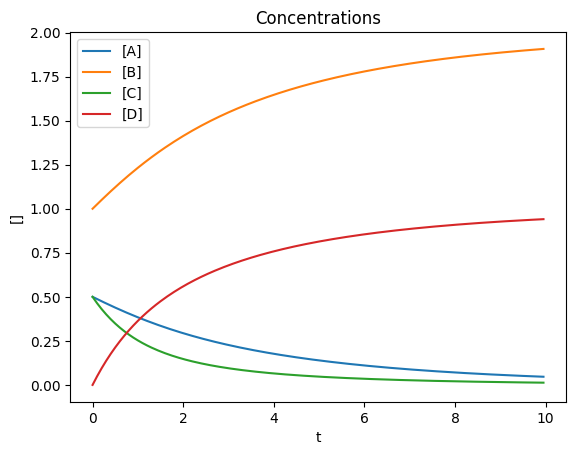

In [8]:
plt.plot(time, A)
plt.plot(time, B)
plt.plot(time, C)
plt.plot(time, D)
plt.xlabel("t")
plt.ylabel("[]")
plt.title("Concentrations")
plt.legend(["[A]", "[B]", "[C]", "[D]"])
plt.show()

And finally the associated total concentrations.

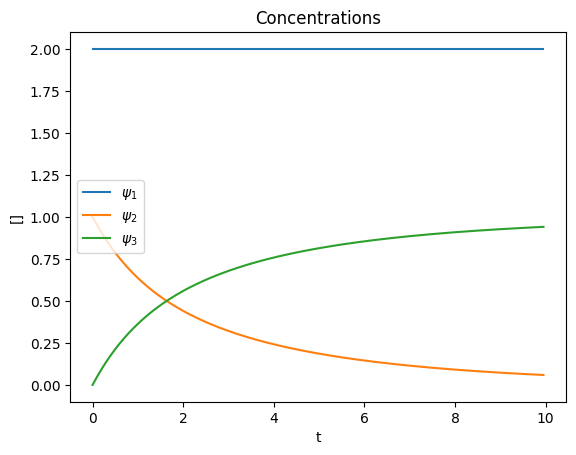

In [9]:
plt.plot(time, conc_t[0])
plt.plot(time, conc_t[1])
plt.plot(time, conc_t[2])
plt.xlabel("t")
plt.ylabel("[]")
plt.title("Concentrations")
plt.legend(["$\\psi_1$", "$\\psi_2$", "$\\psi_3$"])
plt.show()